In [2]:
import time
import numpy as np
from PIL import Image
import sys
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import re

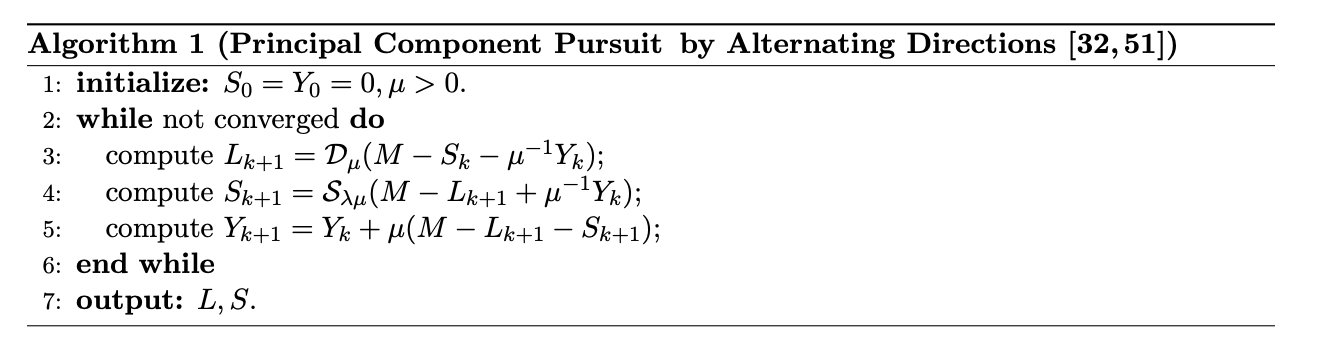

In [3]:
def pcp(M, convergence_rate, mu, maxiter=500):

    shape = M.shape  
    lam = 1.0 / np.sqrt(np.max(shape))

    norm = np.sum(M ** 2)

    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)

    for i in range(maxiter):
        
        # start time
        start = time.time()

        # SVD step. the diagonal entries of s = the singular values
        u ,s ,v = np.linalg.svd(M - S + Y / mu, full_matrices=False)
  
        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        Y += mu * step

        #calc error
        error = np.sqrt(np.sum(step ** 2) / norm)

        #stop time
        iter_time = time.time() - start
        
        print(f"ITERATION -- {i}: error -- {error}, rank -- {rank}, time -- {iter_time} ")

        # check if converge
        if error < convergence_rate:
            break

        i += 1

    return L, S


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

## Download your video(dataset) for decomposition into the current directory

In [24]:
cap = cv2.VideoCapture('final_project.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w, h

(360, 240)

In [5]:
buf = np.empty((frameCount, h, w, 3), np.dtype('uint8'))

for fc in range(frameCount):
    ret, frame = cap.read()
    buf[fc] = cv2.resize(frame,(w,h), fx=0,fy=0, interpolation=cv2.INTER_CUBIC)

M = buf[:,:,:,1].reshape((frameCount, w*h))

In [6]:
M.shape

(500, 86400)

## RUN PCP
### init parameter mu

In [7]:
mu = 0.25 * np.prod(M.shape) / np.sum(np.abs(M))
mu

0.0018203730478013934

In [16]:
L, S = pcp(M, 1e-6,mu, maxiter=50)

ITERATION -- 0: error -- 0.09547896854111992, rank -- 499, time -- 20.465582847595215 
ITERATION -- 1: error -- 0.021798707554405588, rank -- 500, time -- 23.042503356933594 
ITERATION -- 2: error -- 0.017762159628587532, rank -- 500, time -- 21.96077585220337 
ITERATION -- 3: error -- 0.01668593265767663, rank -- 455, time -- 21.763065099716187 
ITERATION -- 4: error -- 0.015756531831749545, rank -- 404, time -- 21.873329639434814 
ITERATION -- 5: error -- 0.014788658283949114, rank -- 371, time -- 21.422842979431152 
ITERATION -- 6: error -- 0.013789409039178007, rank -- 347, time -- 20.648476362228394 
ITERATION -- 7: error -- 0.012826444730801113, rank -- 327, time -- 20.76327395439148 
ITERATION -- 8: error -- 0.011921098512624566, rank -- 308, time -- 20.543620347976685 
ITERATION -- 9: error -- 0.011098320394194441, rank -- 289, time -- 20.550203561782837 
ITERATION -- 10: error -- 0.010313841916688158, rank -- 276, time -- 20.536057472229004 
ITERATION -- 11: error -- 0.0095641

In [21]:
# 500 = number of frames
S.shape

(500, 86400)

# STACK AND SAVE ORIG + LOW RANK + SPARSE to png

In [22]:
import os
os.getcwd()

'/content'

#### create folder for output

In [23]:
from pathlib import Path
Path(os.getcwd() + "/output/").mkdir(parents=True, exist_ok=True)

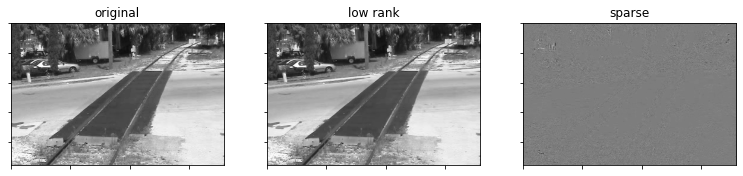

In [25]:
def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

shape = (h,w)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(M)):
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("original")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse")
    fig.savefig(f"output/frame{i}.png")

### show example of output

(288, 936, 3)


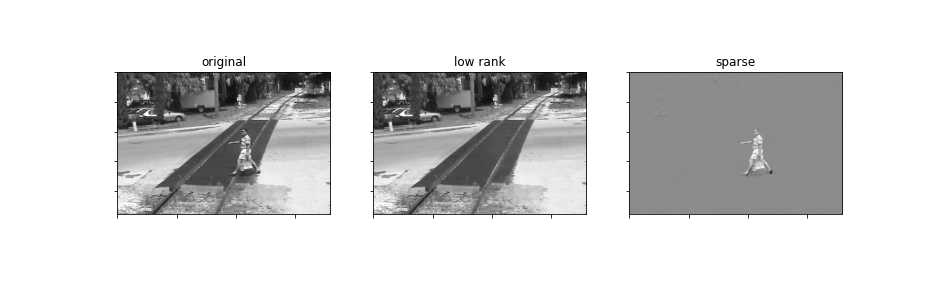

In [26]:
stacked_img = cv2.imread('output/frame340.png')

print(stacked_img.shape)
h, w = stacked_img.shape[:2]

cv2_imshow(stacked_img)

## sort in the correct order

In [27]:
def atoi(text):  
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

sorted_glob = sorted(glob.glob('output/frame*.png'),key=natural_keys)

## create video from frames

In [28]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (w,h))

for filename in sorted_glob:
    img = cv2.imread(filename)
    out.write(img)

out.release()